# VARMA(p,q)
## Vector Autoregressive Moving Average
This lesson picks up where VAR(p) left off.

Recall that the system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$.<br>
Most importantly, $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

In a <strong>VARMA(p,q)</strong> model we give the error terms $\varepsilon_t$ a moving average representation of order $q$.


### Formulation
We've seen that an autoregressive moving average ARMA(p,q) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>


The general steps involved in building a VARMA model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate <em>p</em> and <em>q</em> orders
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html'>
varmax.VARMAX</a></strong><font color=black>(endog[, exog, order, trend, …])</font>&nbsp;&nbsp;Vector Autoregressive Moving Average with eXogenous regressors model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults.html'>
varmax.VARMAXResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an VARMAX model<br>
</tt>
   
<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html#vector-autoregressive-moving-average-with-exogenous-regressors-varmax'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_varmax.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>VARMAX models</font><br>
</div>

In [4]:
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

df = df.join(sp)

## Test for stationarity, perform any necessary transformations
we'll perform the <strong>auto_arima</strong> prediction to identify optimal $p$ and $q$ orders.

In [5]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

It looks like a VARMA(1,2) model is recommended. Note that the $d$ term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [7]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


## Train/test/split
It is useful to define a number of observations variable for our test set. For this analysis, let's use 12 months.

In [8]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

## Fit the VARMA(1,2) Model

In [9]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False) # disp : display
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.068
,+ intercept,AIC,4606.136
Date:,"Fri, 04 Mar 2022",BIC,4665.165
Time:,19:32:26,HQIC,4629.926
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.39, 0.00",Jarque-Bera (JB):,"559.96, 125.81"
Prob(Q):,"0.53, 0.95",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.64, 2.90",Skew:,"1.34, -0.35"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [10]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-12.694635,38.344362
2015-02-01,-10.927281,-5.540071
2015-03-01,1.482099,0.080905
2015-04-01,-1.689457,-0.488199
2015-05-01,1.099531,0.411824
2015-06-01,-0.441778,-0.032076
2015-07-01,0.532000,0.259768
2015-08-01,-0.057235,0.085296
2015-09-01,0.304154,0.192716
2015-10-01,0.083450,0.127192


## Invert the Transformation

In [11]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [12]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [13]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-12.694635,38.344362,65.905365,11657.405365,48.944362,12100.344362
2015-02-01,-10.927281,-5.540071,54.978083,11646.478083,43.404291,12094.804291
2015-03-01,1.482099,0.080905,56.460182,11647.960182,43.485195,12094.885195
2015-04-01,-1.689457,-0.488199,54.770725,11646.270725,42.996997,12094.396997
2015-05-01,1.099531,0.411824,55.870255,11647.370255,43.408821,12094.808821
2015-06-01,-0.441778,-0.032076,55.428478,11646.928478,43.376745,12094.776745
2015-07-01,0.532000,0.259768,55.960477,11647.460477,43.636513,12095.036513
2015-08-01,-0.057235,0.085296,55.903243,11647.403243,43.721809,12095.121809
2015-09-01,0.304154,0.192716,56.207396,11647.707396,43.914524,12095.314524
2015-10-01,0.083450,0.127192,56.290846,11647.790846,44.041717,12095.441717


In [14]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
2015-01-01,11733.2,12046.0,11657.405365,12100.344362
2015-02-01,11852.4,12082.4,11646.478083,12094.804291
2015-03-01,11868.8,12158.3,11647.960182,12094.885195
2015-04-01,11916.1,12193.8,11646.270725,12094.396997
2015-05-01,11947.6,12268.1,11647.370255,12094.808821
2015-06-01,11993.1,12308.3,11646.928478,12094.776745
2015-07-01,12045.3,12355.4,11647.460477,12095.036513
2015-08-01,12096.8,12394.0,11647.403243,12095.121809
2015-09-01,12153.8,12392.8,11647.707396,12095.314524
2015-10-01,12187.7,12416.1,11647.790846,12095.441717


## Plot the results

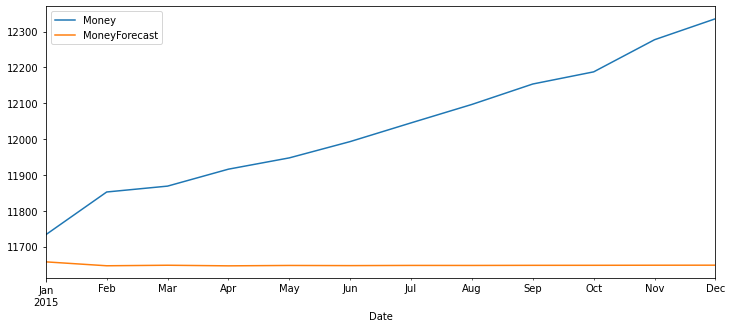

In [15]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

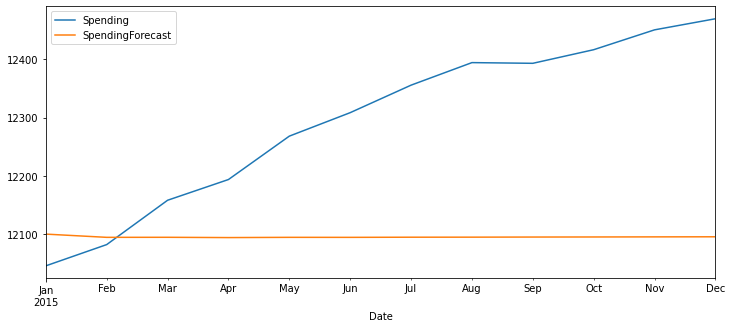

In [16]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

### Evaluate the model

In [17]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 423.940


In [18]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 242.577
